<a href="https://colab.research.google.com/github/thompf2/Machine-Learning-Engineering/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
from google.colab import drive
import xgboost as xgb
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import NearestNeighbors
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_curve
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# mount google drive
drive.mount('/content/drive')

# load and preprocess data
dataset_dir = "/content/drive/MyDrive/Machine Learning Engineering/gt"

# function to load each file efficiently
def process_file(file_path):
    data = np.genfromtxt(file_path, delimiter=" ")
    return pd.DataFrame({
        "x_coords": data[:, 0].astype("float32"),  # Reduce to float32
        "y_coords": data[:, 1].astype("float32"),
        "z_coords": data[:, 2].astype("float32"),
        "defect_label": data[:, 3].astype("int8")  # Reduce to int8
    })

# load and process files one by one
df_list = []
for filename in os.listdir(dataset_dir):
    if filename.endswith(".txt"):
        file_path = os.path.join(dataset_dir, filename)
        df_list.append(process_file(file_path))

# combine all into a single DataFrame
df = pd.concat(df_list, ignore_index=True)

# add spatial features
df["distance_from_origin"] = np.sqrt(df["x_coords"]**2 + df["y_coords"]**2 + df["z_coords"]**2)

# compute curvature approximation (local variation in Z)
df["curvature"] = abs(df["z_coords"] - df["z_coords"].rolling(5, center=True, min_periods=1).mean())

# prepare data with new features
features = ["x_coords", "y_coords", "z_coords", "distance_from_origin", "curvature"]
X = df[features]
y = df["defect_label"]

Mounted at /content/drive


In [2]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, fbeta_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# apply oversmapling
from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(sampling_strategy=0.2, random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

# define parameter grid
param_dist = {
    'n_estimators': [300],  # fixed to reduce combinations
    'max_depth': [9],
    'learning_rate': [0.05],  # fixed value that's working well
    'subsample': [0.8],  # keep consistent sampling
    'colsample_bytree': [0.8],  # fixed for speed
    'gamma': [3, 4],
    'scale_pos_weight': [1.4, 1.5, 1.6],
    'min_child_weight': [1],
}

# # use best parameters from earlier tuning
# best_params = {
#     'subsample': 0.8,
#     'scale_pos_weight': 1.5,
#     'n_estimators': 300,
#     'min_child_weight': 1,
#     'max_depth': 9,
#     'learning_rate': 0.05,
#     'gamma': 3,
#     'colsample_bytree': 0.8
# }

# initialize classifier with base config
xgb_clf = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

# define F2 scorer
f2_scorer = make_scorer(fbeta_score, beta=2)

# random grid search setup
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=15,  # adjust depending on how long you're willing to wait
    scoring=f2_scorer,  # or a custom scorer
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# # initialize final model
# final_model = XGBClassifier(
#     **best_params,
#     objective='binary:logistic',
#     use_label_encoder=False,
#     eval_metric='logloss',
#     random_state=42,
#     early_stopping_rounds=10  # add early stopping here
# )

# smaller sample for speed
sample_size = int(0.5 * len(X_train_resampled))
X_sample = X_train_resampled[:sample_size]
y_sample = y_train_resampled[:sample_size]

# run grid search
random_search.fit(X_sample, y_sample)

# best model and parameters
print("Best Parameters:\n", random_search.best_params_)
best_model = random_search.best_estimator_

# train XGBoost Model, replacing xgb.train with XGBClassifier
best_model.fit(
    X_train_resampled,
    y_train_resampled,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# save the trained best model
import joblib
joblib.dump(best_model, "best_xgb_model.pkl")


# # fit model with early stopping
# final_model.fit(
#     X_train_resampled,
#     y_train_resampled,
#     eval_set=[(X_test, y_test)],
#     verbose=False
# )

y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# find the best threshold using a weighted F-beta score (beta=2 favors recall more)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
fbeta_scores = (1 + 2**2) * (precision * recall) / ((2**2 * precision) + recall)
best_threshold = thresholds[np.argmax(fbeta_scores[:-1])]  # exclude last precision/recall pair

print(f"Optimized Threshold (Weighted Recall): {best_threshold:.4f}")

y_pred = (y_pred_proba > best_threshold).astype(int)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=15. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 6 candidates, totalling 18 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters:
 {'subsample': 0.8, 'scale_pos_weight': 1.6, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.05, 'gamma': 3, 'colsample_bytree': 0.8}
Optimized Threshold (Weighted Recall): 0.7915
Accuracy: 0.9931597296790967
Confusion Matrix:
 [[7094541   42449]
 [   6952   78141]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00   7136990
           1       0.65      0.92      0.76     85093

    accuracy                           0.99   7222083
   macro avg       0.82      0.96      0.88   7222083
weighted avg       0.99      0.99      0.99   7222083



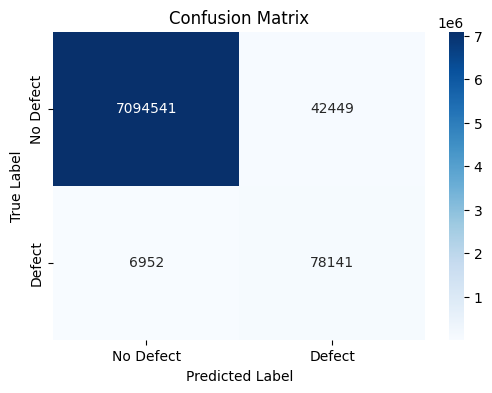

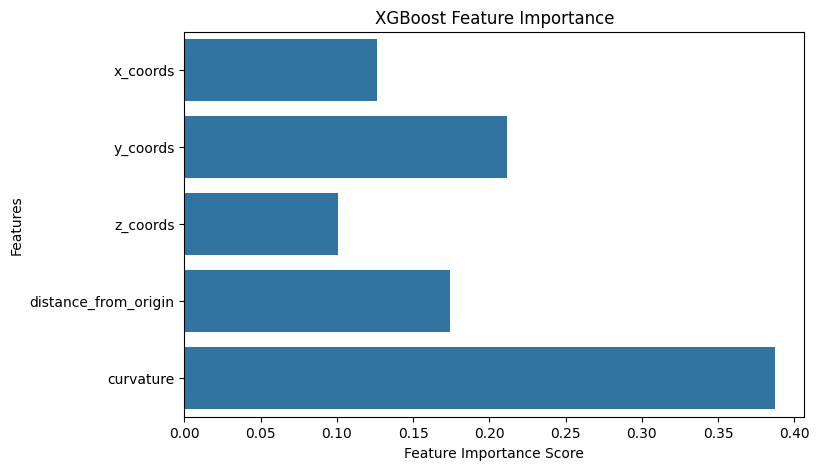

True Defect Rate: 0.9183
False Defect Rate: 0.0059
True Non-Defect Rate: 0.9941
False Non-Defect Rate: 0.0817


In [3]:
# confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Defect", "Defect"], yticklabels=["No Defect", "Defect"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# feature importance visualization
feature_importance = best_model.feature_importances_
plt.figure(figsize=(8, 5))
sns.barplot(x=feature_importance, y=features)
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")
plt.show()

# extract values from confusion matrix
TN, FP, FN, TP = conf_matrix.ravel()

# calculate rates
TrueDefectRate = TP / (TP + FN)
FalseDefectRate = FP / (FP + TN)

TrueNonDefectRate = TN / (TN + FP)
FalseNonDefectRate = FN / (FN + TP)

print(f"True Defect Rate: {TrueDefectRate:.4f}")
print(f"False Defect Rate: {FalseDefectRate:.4f}")
print(f"True Non-Defect Rate: {TrueNonDefectRate:.4f}")
print(f"False Non-Defect Rate: {FalseNonDefectRate:.4f}")

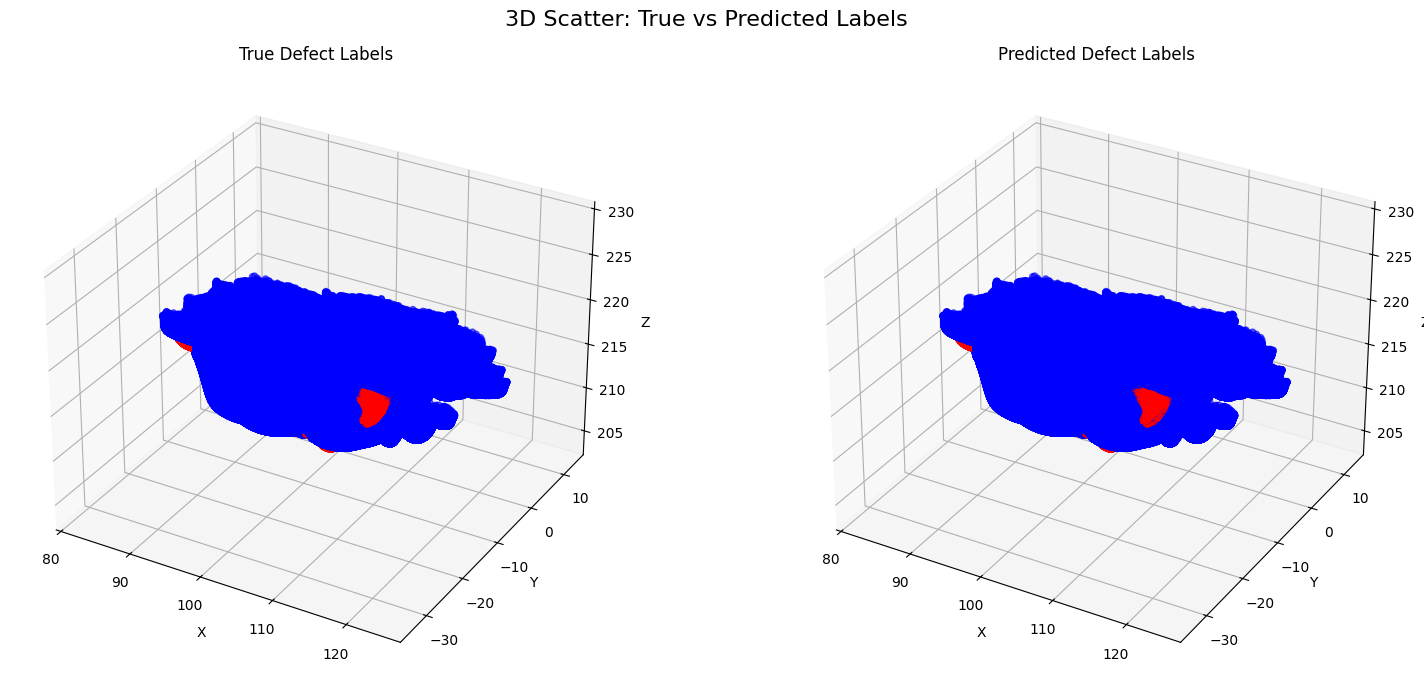

In [4]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# add labels to test set for visualization
viz_df = X_test.copy()
viz_df["True Label"] = y_test.values
viz_df["Predicted Label"] = y_pred

# side by side scatter plot
fig = plt.figure(figsize=(16, 7))

# true labels plot
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
colors_true = ['blue' if label == 0 else 'red' for label in viz_df["True Label"]]
ax1.scatter(viz_df["x_coords"], viz_df["y_coords"], viz_df["z_coords"], c=colors_true, alpha=0.6)
ax1.set_title("True Defect Labels")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_zlabel("Z")

# predicted labels plot
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
colors_pred = ['blue' if label == 0 else 'red' for label in viz_df["Predicted Label"]]
ax2.scatter(viz_df["x_coords"], viz_df["y_coords"], viz_df["z_coords"], c=colors_pred, alpha=0.6)
ax2.set_title("Predicted Defect Labels")
ax2.set_xlabel("X")
ax2.set_ylabel("Y")
ax2.set_zlabel("Z")

plt.suptitle("3D Scatter: True vs Predicted Labels", fontsize=16)
plt.tight_layout()
plt.show()



.
